In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d
import cv2
import cv2.ximgproc as ximgproc

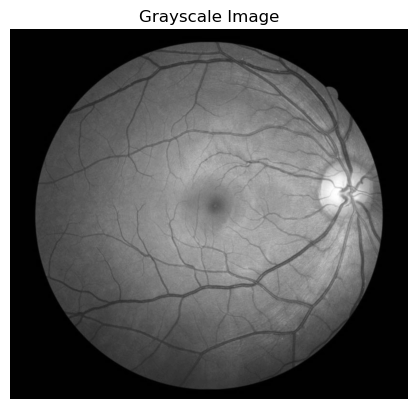

Max Intensity:  247
Min Intensity:  0


In [49]:
# Load the retinal fundus image in grayscale
image_path = 'Fundus.jpeg'
img = cv2.imread(image_path)
if img is None:
    raise IOError("Image not found. Check the image path.")

# Convert to RGB (OpenCV loads images in BGR format by default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()
print("Max Intensity: ",np.max(gray_img))
print("Min Intensity: ",np.min(gray_img))

In [50]:
# Create a CLAHE object for comparison
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gray_img)

In [51]:
def perona_malik_diffusion(img, num_iterations=10, kappa=20, gamma=0.1):
    """
    Perform Perona–Malik anisotropic diffusion on a 2D grayscale image.

    Parameters
    ----------
    img            : 2D numpy array (grayscale image)
    num_iterations : int, number of diffusion iterations
    kappa          : float, edge threshold parameter
    gamma          : float, time-step size (should be <= 0.25 for stability in 2D)

    Returns
    -------
    diffused : 2D numpy array, the filtered image
    """

    # Convert to float32 for numerical stability.
    diffused = img.astype(np.float32)

    for _ in range(num_iterations):
        # Compute finite differences (gradients) in the four directions:
        # North gradient (top neighbor)
        gradN = np.roll(diffused,  1, axis=0) - diffused
        # South gradient (bottom neighbor)
        gradS = np.roll(diffused, -1, axis=0) - diffused
        # East gradient (right neighbor)
        gradE = np.roll(diffused, -1, axis=1) - diffused
        # West gradient (left neighbor)
        gradW = np.roll(diffused,  1, axis=1) - diffused

        # Perona–Malik conduction coefficients in each direction.
        # conduction function: c = exp( - (|gradI| / kappa)^2 )
        cN = np.exp(-(gradN/kappa)**2)
        cS = np.exp(-(gradS/kappa)**2)
        cE = np.exp(-(gradE/kappa)**2)
        cW = np.exp(-(gradW/kappa)**2)

        # Update the image by discrete PDE:
        diffused += gamma * (
            cN * gradN + cS * gradS +
            cE * gradE + cW * gradW
        )

    return diffused

In [56]:
niter = 2  # Too few iterations might not remove enough noise; too many can oversmooth or produce artifacts (especially if gamma is large
kappa = 50  # If you see too much blurring at vessel edges, lower kappa. If you see little noise reduction, increase kappa.
gamma = 0.1  # If you see “ringing” or instability, lower gamma. If you want the same smoothing in fewer iterations, you can raise gamma

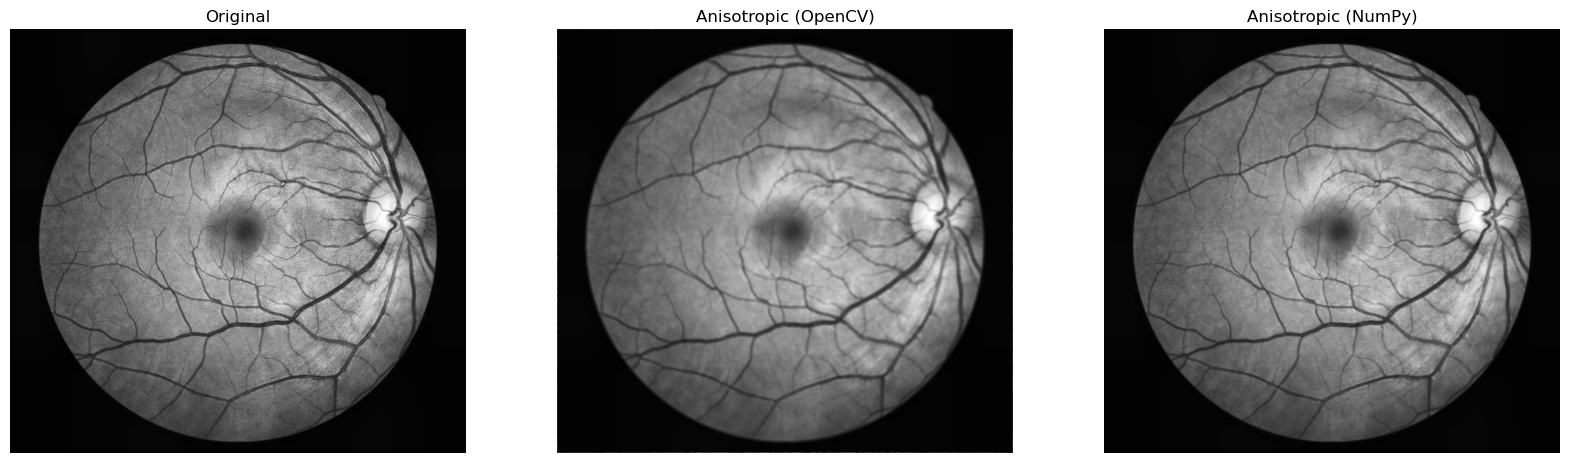

In [59]:
# Apply our pure NumPy Perona–Malik filter
filtered_np = perona_malik_diffusion(clahe_img,
                                     num_iterations=niter,
                                     kappa=kappa,
                                     gamma=gamma)

# alpha ~ "gamma" (time-step), K ~ "kappa", niters = number of iterations
result_cv = ximgproc.anisotropicDiffusion(img,
                                          alpha=gamma,  # like gamma
                                          K=kappa,       # like kappa
                                          niters=niter)  # number of iterations
result_cv = cv2.cvtColor(result_cv, cv2.COLOR_RGB2GRAY)
result_cv = clahe.apply(result_cv)
# Compare original and filtered
plt.figure(figsize=(20,15))
plt.subplot(1,3,1); plt.imshow(clahe_img, cmap='gray'); plt.title('Original'); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(result_cv, cmap='gray'); plt.title('Anisotropic (OpenCV)'); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(filtered_np, cmap='gray'); plt.title("Anisotropic (NumPy)"); plt.axis("off")
plt.show()